# SI 618: Data Manipulation and Analysis
## 06 - Categorical Data & Text Processing 
### Contingency tables, crosstabs, mosaic plots and chi-squared
### Introduction to text processing
### Dr. Chris Teplovs, School of Information, University of Michigan
<small><a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a> This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.


## Overview for today

* Check-in
* Project proposal review 
* Categorical Data: contingency tables, crosstabs, mosaic plots, chi-squared
* Text Processing: regular expressions

# Categorical Data

Categorical data are those that can take on one of a limited number of values (i.e. categories) (Wikipedia)

Examples: blood type (A, B, AB, O); types of rock (sedimentary, metamorphic, igneous).

## Contingency tables, crosstabs, and chi-square

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline

Let's generate a data frame to play with:

In [3]:
df = pd.DataFrame({'color' : ['red', 'green', 'green', 'black'] * 6,
                   'make' : ['ford', 'toyota', 'dodge'] * 8,
                   'vehicleClass' : ['suv', 'suv', 'suv', 'car', 'car', 'truck'] * 4})

In [4]:
df

,color,make,vehicleClass
0,red,ford,suv
1,green,toyota,suv
2,green,dodge,suv
3,black,ford,car
4,red,toyota,car
5,green,dodge,truck
6,green,ford,suv
7,black,toyota,suv
8,red,dodge,suv
9,green,ford,car


One of the most basic transformations we can do is a crosstab:

In [5]:
ct = pd.crosstab(df.color,df.vehicleClass)
ct

vehicleClass,car,suv,truck
color,,,
black,2,2,2
green,4,6,2
red,2,4,0


Notice how similar it is to pivoting.  In fact, go ahead and use ```pivot_table``` to do the same sort of transformation:

### <font color="magenta">Q1: Use ```pivot_table``` to create a DataFrame similar to the one from the ```crosstab``` above:

In [6]:
p = df.pivot_table(index='color',columns='vehicleClass',aggfunc=len) # crosstab basically is pivot table
p

make           
vehicleClass  car  suv truck
color                       
black         2.0  2.0   2.0
green         4.0  6.0   2.0
red           2.0  4.0   NaN

In [7]:
p = df.pivot_table(index='color',columns='vehicleClass',aggfunc=len,fill_value=0) #to remove the NaN value
p

make          
vehicleClass  car suv truck
color                      
black           2   2     2
green           4   6     2
red             2   4     0

In [8]:
p.columns

MultiIndex([('make',   'car'),
            ('make',   'suv'),
            ('make', 'truck')],
           names=[None, 'vehicleClass'])

As usual, we would like to visualize our results:

In [9]:
p.columns = p.columns.droplevel() # to remove the 'make' level
p

vehicleClass,car,suv,truck
color,,,
black,2,2,2
green,4,6,2
red,2,4,0


In [10]:
import seaborn as sns

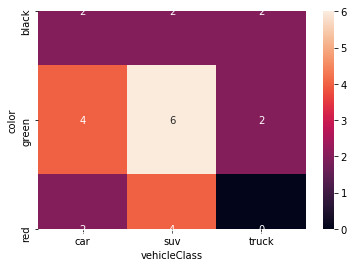

In [11]:
sns.heatmap(ct,annot=True)

You might want to investigate other palettes, see https://seaborn.pydata.org/tutorial/color_palettes.html for more details.



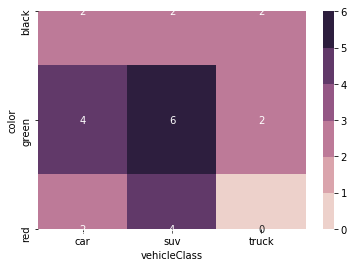

In [12]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette()) # people have color blind will do better in this color scale
# cmap is to specify the color

### Titanic data

One of the more popular datasets that we use for experimenting with crosstabs is the 
survivor data from the Titanic disaster:

In [13]:
titanic = pd.read_csv('data/titanic.csv')

In [14]:
titanic.head()

,passtype,age,status,sex
0,third,child,dead,male
1,third,child,dead,male
2,third,child,dead,male
3,third,child,dead,male
4,third,child,dead,male


Let's create a crosstab of the data:

In [15]:
ct = pd.crosstab(titanic.passtype,titanic.status,margins=False)
ct

status,alive,dead
passtype,,
crew,212,673
first,203,122
second,118,167
third,178,528


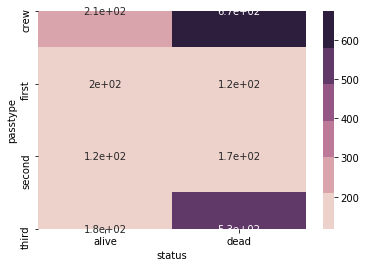

In [16]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette())

Does scientific notation bother you?  Change the format with the ```fmt=``` argument:

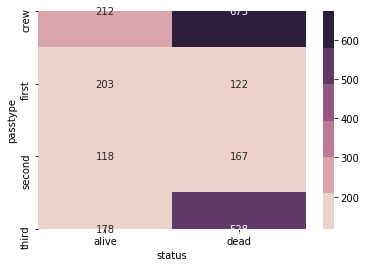

In [17]:
sns.heatmap(ct,annot=True,cmap=sns.cubehelix_palette(),fmt='d')

### <font color="magenta"> Q2: Is there something interesting here?</font>

It's obvious that people in third class has the highest death number, but we don't know the base number of each class, but I think it's more reasonable to compare the death rate instead of death number counts. We still don't know is there bigger chance for first and second class people survive.

In addition to the heatmap shown above, we can use a mosaic plot to visualize 
contingency tables:

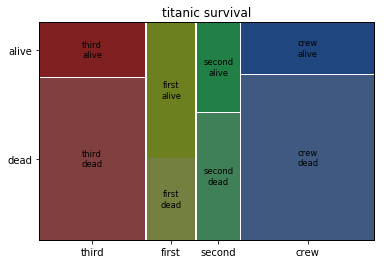

In [18]:
from statsmodels.graphics.mosaicplot import mosaic
t = mosaic(titanic, ['passtype','status'],title='titanic survival')

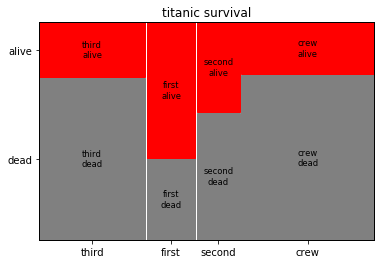

In [19]:
# slightly easier to read
props = lambda key: {'color': 'r' if 'alive' in key else 'gray'}
t = mosaic(titanic, ['passtype','status'],title='titanic survival',properties=props)

Let's take a look at the "expected" values for each cell.  That is,
the values that we would expect if there was no effect of "passtype" on "status".  To do this, let's take a look at the marginal totals:

In [20]:
ct = pd.crosstab(titanic.passtype,titanic.status,margins=True) #margins=true caculate the All value for first 2 colunms 
ct

status,alive,dead,All
passtype,,,
crew,212,673,885
first,203,122,325
second,118,167,285
third,178,528,706
All,711,1490,2201


The **expected** value for each cell (i.e. the value that you would expect if there was no interaction between passtype and status in this dataset) can be calculated by taking the row total multiplied by the column total and divided by the overall total.  

So we would get the following expected value for alive crew:

In [21]:
exp = ct['All'].loc['crew'] * ct['alive'].loc['All'] / ct['All'].loc['All']

In [22]:
exp

285.88596092685145

You could repeat this for each cell (or write code to do so), but you get the idea.

## Let's talk about $\chi^2$

Finally, we can go beyond visual exploration and apply analytic tests to see if the 
observed values differ from the expected ones.  The chi-square test sums the squares of the differences
between the observed and expected values, normalized for the expected values.

Our null hypothesis is that there is no difference in survivorship based on passage type.

Here's a video resource that explains chi-squared:

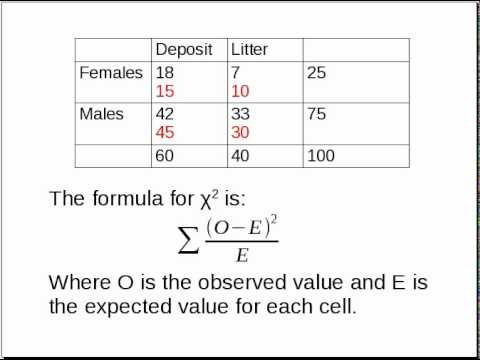

In [23]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("VskmMgXmkMQ")
display(vid)

In [24]:
# This video is really important and helpful.
# How to calculate expect data: total value of row * rotal value of column / total number of everything
# degree of freedom: (row number-1)*(column-1) how many value you have to have before you can give the final conclustion

In [25]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)

chi2 =  190.40110361683327
p-val =  6.705773035354302e-37
degree of freedom =  8


pvalue tell you there's good chance you reject null H0, that there's no relationship betweeen the passage class and death

As a bonus, we also get a DataFrame of the expected values:

In [26]:
pd.DataFrame(ex)

,0,1,2
0,285.885961,599.114039,885.0
1,104.986370,220.013630,325.0
2,92.064970,192.935030,285.0
3,228.062699,477.937301,706.0
4,711.000000,1490.000000,2201.0


## Let's apply these ideas to another dataset

For this component, we'll use the Comic Characters data set:

In [27]:
comic_characters = pd.read_csv("data/comic_characters.csv", index_col="id")
comic_characters.head(1)

,publisher,name,Identity,align,eye,hair,sex,alive,appearances,first_appearance,month,year,date
id,,,,,,,,,,,,,
1,Marvel,Spider-Man (Peter Parker),Secret Identity,Good Characters,Hazel Eyes,Brown Hair,Male Characters,Living Characters,4043.0,"1962, August",August,1962.0,8/1/1962


### Example

We'd like to know which publisher uses different 'identity' types for their characters? Have DC characters appeared more publicly? What is the average number of times Marvel Characters appeared known to authorities identity?

In [28]:
comic_characters.groupby(['Identity','publisher'])['appearances'].mean().unstack().fillna(0)

publisher,DC,Marvel
Identity,,
Identity Unknown,3.000000,0.000000
Known to Authorities Identity,0.000000,74.400000
No Dual Identity,0.000000,24.402013
Public Identity,28.287166,23.407615
Secret Identity,32.655157,17.379794


Alternatively, we can use .pivot_table(). For example:

In [29]:
avg_appearance_per_identity = comic_characters.pivot_table(index='Identity', 
                                                          columns='publisher', 
                                                          values='appearances',
                                                          aggfunc='mean')
avg_appearance_per_identity.fillna(0).head()

publisher,DC,Marvel
Identity,,
Identity Unknown,3.000000,0.000000
Known to Authorities Identity,0.000000,74.400000
No Dual Identity,0.000000,24.402013
Public Identity,28.287166,23.407615
Secret Identity,32.655157,17.379794


For .pivot_table(), you need to specify these four arguments:
1. index: the field that will become the index of the output table
2. columns: the field that will become the columns of the output table
3. values: the field to be aggregated/summarized
4. aggfunc: the aggregation operator applied to values, if there are more than 1 entry corresponding to each (index, column) pair, such as "mean", "count", "max"
    

### Let's warm up with a few groupby and pivot_table exercises:

What is the total number of appearances of characters for each publisher?

In [30]:
a = comic_characters.groupby('publisher')[['appearances']].sum() 
# there is double list mark: [[]], meaning will get a table after done
a.head()

,appearances
publisher,
DC,154532.0
Marvel,260270.0


What is the total number of appearances of characters by each publisher in each year? Output a table.

In [31]:
b = comic_characters.groupby(['year','publisher']).sum().fillna(0)
b

appearances
year   publisher             
1935.0 DC               125.0
1936.0 DC               240.0
1937.0 DC               458.0
1938.0 DC              1639.0
1939.0 DC              4067.0
...                       ...
2011.0 Marvel          1890.0
2012.0 DC                17.0
       Marvel          1072.0
2013.0 DC                 1.0
       Marvel          1177.0

[154 rows x 1 columns]

### Can we improve that output?

Try unstacking it...

In [32]:
b = comic_characters.groupby(['year','publisher']).sum().unstack().fillna(0)
b.head(10)

appearances        
publisher          DC  Marvel
year                         
1935.0          125.0     0.0
1936.0          240.0     0.0
1937.0          458.0     0.0
1938.0         1639.0     0.0
1939.0         4067.0  1013.0
1940.0         9123.0  2160.0
1941.0         6945.0  5371.0
1942.0         4068.0   401.0
1943.0         1475.0   541.0
1944.0          274.0   960.0

Construct a contingency table of sex and character alignment normalized by all values.

Display the normalized values in percentage (%) format. Use brief sentences to explain your findings.  

Hint: use "normalize=all" in your crosstab statement.  What does normalize do? (read the docs)

In [33]:
ct = pd.crosstab(comic_characters['sex'], comic_characters['align'], normalize='all')
ct.apply(lambda x: x.apply(lambda y:  str('{:,.2f}'.format(y*100)) + '%' )) 
# 2f, 2 decimal numbers, formating by the apply function to get a pretty table, like markdown table in homework

align,Bad Characters,Good Characters,Neutral Characters,Reformed Criminals
sex,,,,
Agender Characters,0.10%,0.05%,0.07%,0.00%
Female Characters,8.22%,13.01%,4.37%,0.01%
Genderfluid Characters,0.00%,0.01%,0.01%,0.00%
Genderless Characters,0.06%,0.03%,0.02%,0.00%
Male Characters,39.51%,25.13%,9.40%,0.01%
Transgender Characters,0.01%,0.00%,0.00%,0.00%


### <font color="magenta">Q3: Create a mosaic plot of align and alive.  Conduct a $\chi^2$ test of ```align``` and ```alive```. Please specify your (null and alternative) hypotheses and explain your findings.

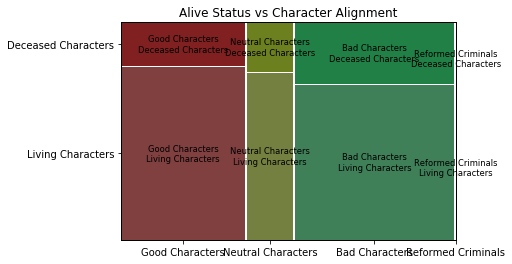

In [34]:
from statsmodels.graphics.mosaicplot import mosaic
t = mosaic(comic_characters, 
           ['align','alive'], 
           title='Alive Status vs Character Alignment')

In [35]:
ct = pd.crosstab(comic_characters['alive'],comic_characters['align'], normalize=False)
# normalize will devide all the values by the total sum values, then we can generate the percentage the value in chart
# chi-square assume all values in the table be at least 5, so don't do normalization in chi-square

In [36]:
from scipy.stats import chi2_contingency
chi2, p, dof, ex = chi2_contingency(ct)
print("chi2 = ", chi2)
print("p-val = ", p)
print("degree of freedom = ",dof)
print("Expected:")
pd.DataFrame(ex, index=ct.index, columns=ct.columns)

chi2 =  155.77673609805584
p-val =  1.4943918171359309e-33
degree of freedom =  3
Expected:


align,Bad Characters,Good Characters,Neutral Characters,Reformed Criminals
alive,,,,
Deceased Characters,2363.193534,1835.44478,681.624263,0.737423
Living Characters,7250.806466,5631.55522,2091.375737,2.262577


The odds get the value 155.78 is very very small (according to the pvalue), and therefore I should reject the H0 (which assume there's no relationship between characters alive value and align value), and there's significant difference for alive for characters in different align.

# BREAK!

# Text Processing I: Basics and Regular Expressions

As usual, let's load up some data:

In [37]:
import pandas as pd

In [38]:
reviews = pd.read_csv('data/amazon_food_reviews.zip')
# if in the zip file, there's only 1 file, then this is how you read the file

Let's take a really small sample, just so we can experiment with the various 

In [39]:
reviews_sample = reviews.head(10)

In [40]:
reviews_sample

,Id,ProductId,User Id,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [41]:
reviews.shape

(99999, 10)

Let's review some basic string functionality from Pandas that can be applied to any Series or Index:

In [42]:
reviews_sample.ProfileName

0                         delmartian
1                             dll pa
2    Natalia Corres "Natalia Corres"
3                               Karl
4      Michael D. Bigham "M. Wassir"
5                     Twoapennything
6                  David C. Sullivan
7                 Pamela G. Williams
8                           R. James
9                      Carol A. Reed
Name: ProfileName, dtype: object

In [43]:
reviews_sample.ProfileName.str.lower()

0                         delmartian
1                             dll pa
2    natalia corres "natalia corres"
3                               karl
4      michael d. bigham "m. wassir"
5                     twoapennything
6                  david c. sullivan
7                 pamela g. williams
8                           r. james
9                      carol a. reed
Name: ProfileName, dtype: object

In [44]:
reviews_sample.ProfileName.str.upper()

0                         DELMARTIAN
1                             DLL PA
2    NATALIA CORRES "NATALIA CORRES"
3                               KARL
4      MICHAEL D. BIGHAM "M. WASSIR"
5                     TWOAPENNYTHING
6                  DAVID C. SULLIVAN
7                 PAMELA G. WILLIAMS
8                           R. JAMES
9                      CAROL A. REED
Name: ProfileName, dtype: object

In [45]:
reviews_sample.Summary.str.len()

0    21
1    17
2    21
3    14
4    11
5    10
6    45
7    22
8    10
9    16
Name: Summary, dtype: int64

Remember, the ```columns``` attribute of a DataFrame is an Index object, which means that we can use str operators on the column names:

In [46]:
reviews_sample.columns

Index(['Id', 'ProductId', 'User Id ', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [47]:
reviews_sample['User Id ']# there's a werid space at the end

0    A3SGXH7AUHU8GW
1    A1D87F6ZCVE5NK
2     ABXLMWJIXXAIN
3    A395BORC6FGVXV
4    A1UQRSCLF8GW1T
5     ADT0SRK1MGOEU
6    A1SP2KVKFXXRU1
7    A3JRGQVEQN31IQ
8    A1MZYO9TZK0BBI
9    A21BT40VZCCYT4
Name: User Id , dtype: object

In [48]:
reviews_sample.columns.str.lower()

Index(['id', 'productid', 'user id ', 'profilename', 'helpfulnessnumerator',
       'helpfulnessdenominator', 'score', 'time', 'summary', 'text'],
      dtype='object')

Notice that the "User Id" column of the dataframe looks weird:  it has a space in the middle *and* at the end.  Columns that are named like that will invariable trip us up in downstream (i.e. later) analyses, so it's wise to correct them now.  Something like the following can help:

In [49]:
reviews_sample.columns.str.strip().str.lower().str.replace(' ','_')

Index(['id', 'productid', 'user_id', 'profilename', 'helpfulnessnumerator',
       'helpfulnessdenominator', 'score', 'time', 'summary', 'text'],
      dtype='object')

And we can assign that back to the columns attribute to actually rename the columns:


In [50]:
reviews_sample.columns = reviews_sample.columns.str.strip().str.lower().str.replace(' ','_')

In [51]:
reviews_sample

,id,productid,user_id,profilename,helpfulnessnumerator,helpfulnessdenominator,score,time,summary,text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


### Splitting and Replacing Strings

Sometimes, we want to split strings into lists.  We might want to do that with the "summary" column:

In [52]:
reviews_sample.productid.head()

0    B001E4KFG0
1    B00813GRG4
2    B000LQOCH0
3    B000UA0QIQ
4    B006K2ZZ7K
Name: productid, dtype: object

In [53]:
reviews_sample.productid.str.split('00')

0    [B, 1E4KFG0]
1    [B, 813GRG4]
2    [B, 0LQOCH0]
3    [B, 0UA0QIQ]
4    [B, 6K2ZZ7K]
5    [B, 6K2ZZ7K]
6    [B, 6K2ZZ7K]
7    [B, 6K2ZZ7K]
8    [B, 0E7L2R4]
9    [B, 171APVA]
Name: productid, dtype: object

In [54]:
reviews_sample.productid.str.split('00').str.get(1)

0    1E4KFG0
1    813GRG4
2    0LQOCH0
3    0UA0QIQ
4    6K2ZZ7K
5    6K2ZZ7K
6    6K2ZZ7K
7    6K2ZZ7K
8    0E7L2R4
9    171APVA
Name: productid, dtype: object

Equivalently:

In [55]:
reviews_sample.productid.str.split('00').str[1]

0    1E4KFG0
1    813GRG4
2    0LQOCH0
3    0UA0QIQ
4    6K2ZZ7K
5    6K2ZZ7K
6    6K2ZZ7K
7    6K2ZZ7K
8    0E7L2R4
9    171APVA
Name: productid, dtype: object

### Replace (regex time!)

In [56]:
reviews_sample.summary.iloc[0]

'Good Quality Dog Food'

In [57]:
reviews_sample.summary.str.lower().str.replace('dog','health')

0                         good quality health food
1                                not as advertised
2                            "delight" says it all
3                                   cough medicine
4                                      great taffy
5                                       nice taffy
6    great!  just as good as the expensive brands!
7                           wonderful, tasty taffy
8                                       yay barley
9                              healthy health food
Name: summary, dtype: object

In [58]:
reviews_sample.summary.str.lower().str.replace('dog|taffy','health') # | means or

0                         good quality health food
1                                not as advertised
2                            "delight" says it all
3                                   cough medicine
4                                     great health
5                                      nice health
6    great!  just as good as the expensive brands!
7                          wonderful, tasty health
8                                       yay barley
9                              healthy health food
Name: summary, dtype: object

### Extracting Substrings

In [59]:
reviews_sample.summary.str.extract(r'(Dog)') 

,0
0,Dog
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
6,NaN
7,NaN
8,NaN
9,Dog


r stands for raw, meaning extract a raw string, it will skip for example, \n, new line or \t, tab indent, \d, digits, \D, non-digits, \s, white space

In [60]:
reviews_sample.summary.str.extract(r'(Dog|Taffy)')

,0
0,Dog
1,NaN
2,NaN
3,NaN
4,NaN
5,Taffy
6,NaN
7,NaN
8,NaN
9,Dog


In [61]:
# reviews_sample.summary.iloc[0] = 'Dog Taffy tafy'
# for extract, it will only return the first match, even there are dog and taffy

In [62]:
reviews_sample.summary.str.extract(r'(Dog|[Tt]aff?y)')
# the square bracket [Tt] means get taffy either T is capital or not
# the ? behind 'ff' means if someone spell taffy wrongly, like tafy, then the second f has a ? mark
# 

,0
0,Dog
1,NaN
2,NaN
3,NaN
4,taffy
5,Taffy
6,NaN
7,taffy
8,NaN
9,Dog


In [63]:
# returns a Series
reviews_sample.summary.str.extract(r'(Dog|[Tt]affy)', expand = False)

0      Dog
1      NaN
2      NaN
3      NaN
4    taffy
5    Taffy
6      NaN
7    taffy
8      NaN
9      Dog
Name: summary, dtype: object

In [64]:
reviews_sample.summary.str.extractall(r'(Dog|[Tt]affy)').unstack()

,0
match,0
0,Dog
4,taffy
5,Taffy
7,taffy
9,Dog


In [65]:
reviews_sample.summary.str.extractall(r'(as)')

0
  match    
1 0      as
6 0      as
  1      as
7 0      as

### Testing for Strings that Match or Contain a Pattern

In [66]:
reviews_sample.text

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: text, dtype: object

In [67]:
pattern = r'[Gg]ood'

In [68]:
reviews_sample.text.str.contains(pattern)
reviews_sample.summary.str.extract(r'(Dog|Taffy)')

,0
0,Dog
1,NaN
2,NaN
3,NaN
4,NaN
5,Taffy
6,NaN
7,NaN
8,NaN
9,Dog


In [69]:
reviews_sample[reviews_sample.text.str.contains(pattern)] #it can be used as filter

,id,productid,user_id,profilename,helpfulnessnumerator,helpfulnessdenominator,score,time,summary,text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
7,8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
9,10,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


In [70]:
reviews_sample.text.str.match(pattern)

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
Name: text, dtype: bool

In [71]:
pattern = r'(.*[Gg]ood.*)' # period . means any charactor, * means 0 or more charactors at left and right side

In [72]:
reviews_sample.text.str.match(pattern)

0     True
1    False
2    False
3     True
4    False
5    False
6    False
7     True
8    False
9     True
Name: text, dtype: bool

#### Helpful resources:
- Pandas text documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/text.html
- Regex Cheat Sheet: https://regexr.com/

### <font color="magenta">Q4: How many rows from the Amazon Food Reviews data set contain the word ```vegan``` in the  ```Text``` column?</font>

In [73]:
reviews.columns = reviews.columns.str.strip().str.lower().str.replace(' ','_')

In [74]:
reviews.text.str.contains('[Vv]egan').value_counts()
# Chris used sum(), this function only count the true value of bollen results

False    99430
True       569
Name: text, dtype: int64

There are 569 rows containing the word 'vegan' (first letter not case sensitive') in the Text column in the reviews dataset.

In [75]:
reviews.text.str.contains('[Vv]egetarian|[Vv]egan').sum()

923

In [76]:
reviews.text.str.contains(r'[Vv]eg|an|etarian|ism').sum()

92362

### <font color="magenta">Q5: How many rows from the Amazon Food Reviews data set contain HTML tags in the ```Text``` column?</font>
Hint: here's how to find an HTML tag: https://stackoverflow.com/questions/45999415/removing-html-tags-in-pandas.  Explain what the regex means.

In [77]:
reviews.text.str.contains('<[^<]+?>').value_counts()

False    73424
True     26575
Name: text, dtype: int64

There are 26575 rows containing the HTML tags in the Text column reviews dataset.

### <font color="magenta">  Stretch: Remove all HTML tags from the Amazon Food Reviews text column and save the results to a column called text_no_html.

In [78]:
reviews['text_no_html']=reviews.text.str.replace('<[^<]+?>', ' ')

In [79]:
reviews.head()

,id,productid,user_id,profilename,helpfulnessnumerator,helpfulnessdenominator,score,time,summary,text,text_no_html
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,Great taffy at a great price. There was a wid...
